# L5 - Long-range interactions

## 5.1 - Overview

For systems of particles with short-range interactions, the potential energy, forces, and other properties can be calculated in a straightforward and efficient way, using the minimum-image convention (for periodic systems) or spherical truncation of interactions (in general). Approximate long-range corrections to the potential energy and pressure may also be applied.

The situation is more complicated in systems with *long-range* interactions that fall off with distance $r$ no faster than $\sim r^{-d}$, where $d$ is the spatial dimensionality. Important examples include systems of particles with Coulombic, dipolar, gravitational, or hydrodynamic interactions. In such systems, simple truncation of pair interactions leads to highly inaccurate results, and calculating all pairwise interactions without truncation in a brute force fashion entails $O(N^2)$ computational cost in a system of $N$ particles, and yields ill-defined properties in systems with periodic boundary conditions.

A variety of methods have been developed to deal with these issues, including the *Ewald summation method* for computing electrostatic interactions in periodic systems of charged particles, in which a conditionally convergent sum over a periodic array of unit cells is replaced by two rapidly convergent sums, one in real space and the other in Fourier space. When optimized with respect to a free convergence parameter, the computational cost of the Ewald summation method scales as $O(N^{3/2})$.

For large $N$, even better scaling can be achieved with *grid-based methods* such as the smooth particle mesh Ewald (SPME) and particle-particle particle-mesh (PPPM) methods, in which the real-space charge density is mapped onto a regular grid, enabling use of the fast Fourier transform (FFT) to compute the Fourier-space part of the Ewald sum. The computational complexity of these methods is that of the FFT algorithm, $O(N \ln N)$.

Finally, multiscale methods such as the *fast multipole method* (FMM) achieve $O(N)$ scaling, albeit at the cost of additional algorithmic complexity, and are the fastest methods for simulating very large systems. Unlike Ewald-based methods, the FFM method is easily adapted to non-periodic systems, which makes it an attractive method for cosmological and fluid dynamics simulations (but the PPPM method is also an attractive option).

## 5.2 - Periodic boundary conditions and long-range interactions

Periodic boundary conditions are conventionally employed to minimize finite-size effects in computer simulations, but may introduce complications in the case of long-range interactions. Assuming a pairwise additive potential, the potential energy for a 3D system can be written as a lattice sum over all periodic images of the simulation box,

$$
U = \frac{1}{2} {\sum_{\bf n}}^\prime \sum_{i = 1}^N \sum_{j = 1}^N u(|{\bf r}_{ij} + {\bf n} L|).
$$

Here the sum on ${\bf n} = (n_x, n_y, n_z)$ ranges over all triplets of integers, and $L$ is the linear dimension of the periodic box, assumed to be cubic. The prime on the sum over ${\bf n}$ indicates that we omit the self-interaction term $i = j$ for ${\bf n} = 0$.

For short-range interactions, we avoided summing over all periodic cells by truncating the pair potential at a cutoff distance $r_c < L/2$, in which case the total potential energy for a spherically symmetric pair potential can be written

$$
U = \sum_{i <j}^N u(r_{ij}) + \frac{N \rho}{2} \int_{r_c}^\infty dr\ u(r)\ 4 \pi r^2.
$$

Note that for power-law potentials of the form $u(r) \propto r^{-n}$, the tail 'correction' diverges for $n \leq 3$, and the simple truncation scheme fails. In such cases, special care must be taken in evaluating long-range interactions, and the lattice sum needs to be evaluated explicitly.

Here we discuss the Ewald summation method for evaluating such lattice sums for point charges ($n = 1$) and point dipoles ($n = 3$).

## 5.3 - Ewald sums for point charges

The potential energy of a periodic system of point charges can be written

$$
U^\mathrm{coul} = \frac{1}{2} {\sum_{\bf n}}^\prime \sum_{i = 1}^N \sum_{j = 1}^N \frac{q_i q_j}{|{\bf r}_{ij} + {\bf n} L|},
$$

where, as before, the sum on ${\bf n} = (n_x, n_y, n_z)$ ranges over all triplets of integers, and $L$ is the linear dimension of the periodic box, assumed to be cubic. The prime on the sum over ${\bf n}$ indicates that we omit the self-interaction term $i = j$ for ${\bf n} = 0$. We assume that the system is electrically neutral, $\sum_{i = 1}^N q_i = 0$. To simplify the notation, we use Gaussian units (hence avoiding factors of $4 \pi \epsilon_0$). 

This sum is *conditionally convergent*: the value of the sum depends on the order in which the terms in the sum over ${\bf n}$ are added up.

To proceed further, it's convenient to write the total energy as

$$
U^\mathrm{coul} = \frac{1}{2} \sum_{i = 1}^N q_i \Phi({\bf r}_i),
$$

where $\Phi({\bf r}_i)$ is the electrostatic potential at the position of ion $i$,

$$
\Phi({\bf r}_i) = {\sum_{\bf n}}^\prime \sum_{j = 1}^N \frac{q_j}{|{\bf r}_{ij} + {\bf n} L|}.
$$

This conditionally convergent sum can be converted into two absolutely convergent sums by introducing a convergence factor, that cleverly exploits the linearity of Poisson's equation, $\nabla^2 \Phi({\bf r}) = - 4 \pi \rho({\bf r})$, where $\rho({\bf r})$ is the charge density. For point charges, the charge density is a sum of delta functions,

$$
\rho({\bf r}) = \sum_{i = 1}^N q_i \delta({\bf r} - {\bf r}_i).
$$

The Ewald method is a clever trick to exploit the superposition principle to recast the potential energy into an absolutely convergent sum.

The first step is to consider surrounding every charge $q_i$ with a diffuse charge distribution of equal and opposite total charge, thus screening the point charge and ensuring that the potential produced by each charge goes to zero rapidly at large distances. **Why does this screen? Put in a plot of the screened version?**

The potential energy contributions from these screened charges can be summed directly, as they are short-ranged, but we then need to compensate for the addition of fictitious screening charge distributions.

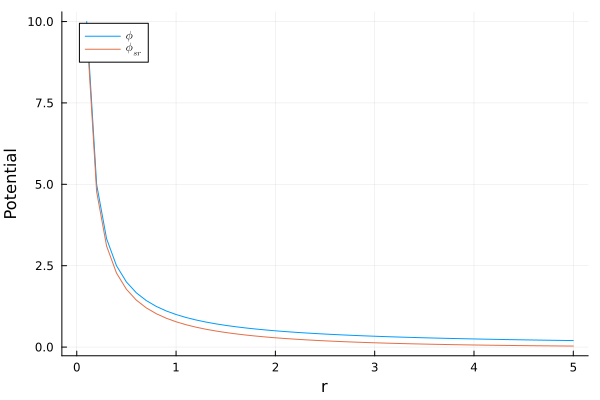

In [13]:
using Revise;
using SpecialFunctions;
using Plots;
using LaTeXStrings;

# Plot what 1/r potential looks like, along with the compensatory screened version.

alpha = 0.2;
rvec = 0:0.1:5.0;
phi = zeros(length(rvec));
phi_sr = zeros(length(rvec));
phi_lr = zeros(length(rvec));

for idx in eachindex(rvec)
    r = rvec[idx];
    phi[idx] = 1.0 / r;
    phi_sr[idx] = erfc(alpha*r)/r;
    # phi_lr[idx] = 
end

philabels = [L"""$\phi$""" L"""$\phi_{\rm sr}$"""];

plot(rvec, [phi, phi_sr], label=philabels, xlabel="r", ylabel="Potential", legend=:topleft)

The compensating charge distribution is just the screening charge distribution with opposite sign, a mirrored version of the diffuse charge distribution that was added to the point charges.

This compensating charge distribution is a smoothly varying periodic function that gives rise to potential energy contributions that converge rapidly in Fourier space.

Point charges can be represented by a superposition of screened charges with their compensating distributions. Superposition ensures that the electrostatic potential produced by the point charge distribution shown on the left is equal to the sum of the potentials produced by the two charge distributions shown on the right. 

<img src="../images/Frenkel_Fig_12.1.png" alt="Drawing" style="width: 600px;">

Figure from *Understanding Molecular Simulation: From Algorithms to Applications*, by Daan Frenkel and Berend Smit.

A conventional and convenient choice of screening charge distribution is a Gaussian distribution,

$$
\rho_G({\bf r}) = - q_i (\alpha^2/\pi)^{3/2} \exp(- \alpha^2 r^2).
$$

As we'll see, this is particularly convenient because the Fourier transform of a Gaussian is a Gaussian. The parameter $\alpha$ is chosen for computational efficiency, and can be used to validate the Ewald procedure, as the total energy can't depend on the value of $\alpha$.

The charge density of a point charge $q_i$ surrounded by a Gaussian charge distribution with net charge $-q_i$ located at the origin is

$$
\rho_{\rm sr}({\bf r}) = q_i \left[ \delta({\bf r}) - (\alpha^2/\pi)^{3/2} \exp(- \alpha^2 r^2) \right]
$$

$$
\rho_{\rm lr}({\bf r}) = q_i (\alpha^2/\pi)^{3/2} \exp(- \alpha^2 r^2)
$$


### Fourier-space contribution

Given the Gaussian form above, a periodic sum of compensating charge distributions has the form

$$
\rho_1({\bf r}) = \sum_{j = 1}^N \sum_{\bf n} q_j (\alpha^2/\pi)^{3/2} \exp \left[ - \alpha^2 |{\bf r} - ({\bf r}_j + {\bf n} L)|^2  \right].
$$

To compute the electrostatic potential due to this charge distribution we use Poisson's equation in Fourier space,

$$
k^2 \Phi_1({\bf k}) = 4 \pi \rho_1({\bf k}).
$$

Here

$$
\rho_1({\bf k}) = \int_V d{\bf r} e^{- i {\bf k} \cdot {\bf r}} \rho_1 ({\bf r})
= \int_V d{\bf r} e^{- i {\bf k} \cdot {\bf r}} \sum_{j = 1}^N \sum_{\bf n} q_j (\alpha^2/\pi)^{3/2} \exp \left[ - \alpha^2 |{\bf r} - ({\bf r}_j + {\bf n} L)|^2  \right]
$$
$$
= \int_\mathrm{all\ space} d{\bf r} e^{- i {\bf k} \cdot {\bf r}} \sum_{j = 1}^N q_j (\alpha^2/\pi)^{3/2} \exp \left[ - \alpha^2 |{\bf r} - {\bf r}_j|^2  \right]
$$
$$
= \sum_{j = 1}^N q_j e^{- i {\bf k} \cdot {\bf r}_j} \exp(-k^2 / 4 \alpha^2).
$$

Inserting this into Poisson's equation then gives

$$
\Phi_1({\bf k}) = \frac{4 \pi}{k^2} \sum_{j = 1}^N q_j e^{- i {\bf k} \cdot {\bf r}_j} \exp(-k^2 / 4 \alpha^2).
$$

This expression is valid for $k \neq 0$, which is related to the sum being conditionally convergent. The real-space potential is obtain from an inverse Fourier transform,

$$
\phi_1({\bf r}) = \frac{1}{V} \sum_{{\bf k} \neq 0} \Phi_1({\bf k}) e^{i {\bf k} \cdot {\bf r}_j}
= \frac{4 \pi q_j}{k^2 V} \sum_{j = 1}^N \sum_{{\bf k} \neq 0} e^{i {\bf k} \cdot ({\bf r} - {\bf r}_j)} \exp(-k^2 / 4 \alpha^2),
$$

so the long-range contribution to the energy is

$$
U_\mathrm{long-range}^\mathrm{coul} = \frac{1}{2} \sum_{i = 1}^N q_i  \phi_1({\bf r}_i)
= \frac{1}{2} \sum_{{\bf k} \neq 0} \sum_{i, j = 1}^N \frac{4 \pi q_i q_j}{k^2 V} e^{i {\bf k} \cdot ({\bf r}_i - {\bf r}_j)} \exp(-k^2 / 4 \alpha^2)
$$

$$
= \frac{1}{2 V} \sum_{{\bf k} \neq 0} \frac{4 \pi}{k^2} |\rho({\bf k})|^2 \exp(-k^2 / 4 \alpha^2)
$$

where $\rho({\bf k}) = \sum_{i = 1}^N q_i \exp(i {\bf k} \cdot {\bf r}_i)$ is the Fourier transform of the charge density.



### Self-interaction correction

The Fourier-space contribution to the potential energy includes spurious self-interaction terms $(1/2) q_i \Phi_\mathrm{gauss}({\bf r}_i)$ due to the interaction between a Gaussian charge cloud of charge $q_i$ and a point charge $q_i$ located at the center of the Gaussian. These terms need to be subtracted out, so we need to calculate the corresponding potential energy, which involved computing the electrostatic potential energy at the center of a Gaussian cloud of charge,

$$
\rho_\mathrm{gauss}({\bf r}) = q_i (\alpha^2/\pi)^{3/2} \exp(- \alpha^2 r^2).
$$

We start with Poisson's equation in spherical coordinates, making use of the spherical symmetry of the charge distribution to obtain

$$
- \frac{1}{r} \frac{\partial^2}{\partial r^2} \left[ r \Phi_\mathrm{gauss}(r) \right] = 4 \pi \rho_\mathrm{gauss}(r)
$$
or
$$
- \frac{\partial^2}{\partial r^2} \left[ r \Phi_\mathrm{gauss}(r) \right] = 4 \pi r \rho_\mathrm{gauss}(r)
$$

This can be integrated to obtain

$$
- \frac{\partial}{\partial r} \left[ r \Phi_\mathrm{gauss}(r) \right]
= \int_\infty^r dr^\prime 4 \pi r \rho_\mathrm{gauss}(r^\prime)
= - 2 \pi q_i (\alpha^2 / \pi)^{3/2} \int_r^\infty {dr^\prime}^2 \exp(- \alpha^2 {r^\prime}^2)
$$
$$
= - 2 q_i (\alpha^2 / \pi)^{1/2} \exp(- \alpha^2 r^2),
$$

and a second integration yields

$$
r \Phi_\mathrm{gauss}(r) = 2 q_i (\alpha^2 / \pi)^{1/2} \int_0^r dr^\prime \exp(- \alpha^2 {r^\prime}^2)
= q_i \mathrm{erf}(\alpha r)
$$
or
$$
\Phi_\mathrm{gauss}(r) = q_i \frac{\mathrm{erf}(\alpha r)}{r},
$$

where the *error function* is defined as

$$
\mathrm{erf}(x) \equiv \frac{2}{\sqrt{\pi}} \int_0^x \exp(-t^2) dt
$$

To calculate the self-energy correction, we need to calculate $\Phi_\mathrm{gauss}(r)$ at $r = 0$, which is

$$
\Phi_\mathrm{gauss}(0) = \frac{2 q_i \alpha}{\sqrt{\pi}},
$$

so the total self-interaction contribution is

$$
U_\mathrm{self}^\mathrm{coul} = \frac{1}{2} \sum_{i = 1}^N q_i \Phi_\mathrm{gauss}(0) 
= \frac{\alpha}{\sqrt{\pi}} \sum_{i = 1}^N q_i^2.
$$

This spurious contribution needs to be *subtracted* from the Fourier space energy.

### Real-space contributions

To compute the short-range part of the Ewald sum, we need to compute interactions among Gaussian-screened point charges. This can be done easily using the result from the last section for the potential due to a Gaussian charge distribution, and we immediately obtain

$$
\Phi_\mathrm{short-range}({\bf r}) = \frac{q_i}{r} - \frac{q_i}{r} \mathrm{erf}(\alpha r)
= \frac{q_i}{r} \mathrm{erfc}(\alpha r)
$$

where $\mathrm{erfc}$ is the complementary error function,

$$
\mathrm{erfc}(x) \equiv \frac{2}{\sqrt{\pi}} \int_x^\infty \exp(-t^2) dt.
$$

The total short-range contribution to the Coulomb potential energy is therefore

$$
U_\mathrm{short-range}^\mathrm{coul} = \frac{1}{2} \sum_{i \neq j}^N q_i q_j \frac{\mathrm{erfc}(\alpha r_{ij})}{r_{ij}}
$$

### Total Coulomb energy

Putting all the pieces together, the total electrostatic energy becomes

$$
U^\mathrm{coul} = \frac{1}{2} \sum_{i \neq j}^N q_i q_j \frac{\mathrm{erfc}(\alpha r_{ij})}{r_{ij}} + \frac{1}{2V} \sum_{{\bf k} \neq 0} \frac{4 \pi}{k^2} |\rho({\bf k})|^2 \exp(- k^2/4 \alpha^2) - \frac{\alpha}{\sqrt{\pi}} \sum_{i = 1}^N q_i^2.
$$